In [2]:
from PIL import Image #import Python Image Library
import numpy as np
import os
import glob
import re
import keras
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import mlutils
import tensorflow as tf

%matplotlib inline

Using TensorFlow backend.
/opt/miniconda/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
L=os.listdir('./')
print(L)

['LandCover.ipynb', 'ImgsSat', 'split', 'EuroSAT.zip', 'Images', 'mlutils.py', 'LULC_Final.ipynb', '.ipynb_checkpoints', 'mlutils.pyc']


-Transfer learning: Alexnet conv1-2 - Architecture(U3.14:inceptionv3)
-Oclusión: máscaras para mostrar objetivo, etiquetado, image segmentation, mapa de calor

-Variaciones a la arquitectura: Archivo de experimentación: loss function, epocas, padding, activation, batch normalization: forma de estandarización de las imgs

-Matriz de confusión-Gráfica de confusión para una imagen U1.2
-Resultado: mlutils.lcurve: para mostrar desempeño en las diferentes épocas
-Textura

# Descarga de imágenes

In [4]:
#Bajar datos --Pendiente
directorio = os.listdir('./')
if 'ImgsSat' in directorio:
    pass
else:
    !mkdir ImgsSat
    !wget http://madm.dfki.de/files/sentinel/EuroSAT.zip -P ImgsSat
    !unzip ImgsSat/EuroSAT.zip -d ImgsSat

# Separación de las imágenes en train y test

In [5]:
#(En máquina virtual tarda unos # minutos)
import random
import shutil

random.seed(42)
# variables
path_to_all_images = "ImgsSat/2750" #Carpeta donde están las imágenes
path_to_split_datasets = "split" #Carpeta donde se van a separar
percentage_validation = 0.3 # percentage of validation data (between 0 an 1)
delete_old_path_to_split_datasets = True #Borrar los train-test anteriores

# Rutas a las carpetas
path_to_home = os.path.expanduser("~")
path_to_all_images = path_to_all_images.replace("~", path_to_home)
path_to_split_datasets = path_to_split_datasets.replace("~", path_to_home)
# Borra y crea carpetas
shutil.rmtree('split')
os.makedirs('split')
if delete_old_path_to_split_datasets and os.path.isdir(path_to_split_datasets):
    shutil.rmtree(path_to_split_datasets)
path_to_train = os.path.join(path_to_split_datasets, "train")
path_to_validation = os.path.join(path_to_split_datasets, "test")
if not os.path.isdir(path_to_train):
    os.makedirs(path_to_train)
if not os.path.isdir(path_to_validation):
    os.makedirs(path_to_validation)

# Copia los archivos
sub_dirs = [sub_dir for sub_dir in os.listdir(path_to_all_images)
            if os.path.isdir(os.path.join(path_to_all_images, sub_dir))] #Clases
for sub_dir in mlutils.pbar()(sub_dirs):
    # list and shuffle images in class directories
    current_dir = os.path.join(path_to_all_images, sub_dir)
    files = os.listdir(current_dir)
    random.shuffle(files)
    # split files into train and validation set
    split_idx = int(len(files)*percentage_validation)
    files_for_validation = files[:split_idx]
    files_for_train = files[split_idx:]
    # copy files to path_to_split_datasets
    if not os.path.isdir(os.path.join(path_to_train, sub_dir)):
        os.makedirs(os.path.join(path_to_train, sub_dir))
    if not os.path.isdir(os.path.join(path_to_validation, sub_dir)):
        os.makedirs(os.path.join(path_to_validation, sub_dir))
    for file in files_for_train:
        shutil.copy2(os.path.join(current_dir, file),
                     os.path.join(path_to_train, sub_dir))
    for file in files_for_validation:
        shutil.copy2(os.path.join(current_dir, file),
                     os.path.join(path_to_validation, sub_dir))

100% (10 of 10) |#########################| Elapsed Time: 0:03:42 Time: 0:03:42


In [4]:
#!!!!!Forma alternativa de separación, requiere mas tiempo!!!!!!!!!!!!!!!!
# for classdir in classdirs:
#     print classdir
#     print "    splitting files ... ",
#     files = !find $downloads/$classdir -type f
#     files = np.r_[files]
#     n_train = int(len(files)*train_pct) 
#     files = np.random.permutation(files)
#     files_train = files[:n_train]
#     files_test  = files[n_train:]
#     !mkdir -p $traintest_imgs/train/$classdir
#     !mkdir -p $traintest_imgs/test/$classdir
#     print "copying files"
#     for f in files_train:
#         !cp '$f' $traintest_imgs/train/$classdir
#     for f in files_test:
#         !cp '$f' $traintest_imgs/test/$classdir

In [6]:
#nombres de categorías
downloads = "Images" #Direcciones donde se guardarán las imgs
traintest_imgs = "split"
train_pct = .7
classdirs = !find $downloads -type d
classdirs = [i.split("/")[-1] for i in classdirs if i!=downloads]
#Saber número de imágenes para train y test de cada categoría
for classdir in classdirs:
    print classdir
    files = !find  $traintest_imgs/train/$classdir -type f
    print "      ",len(files), "train images"
    files = !find  $traintest_imgs/test/$classdir -type f
    print "      ",len(files), "test images"

.ipynb_checkpoints
       1 train images
       1 test images


In [7]:
#Generador de las imágenes
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(rescale=1./255, fill_mode='nearest')
batch_size = 10
img_size = 64 #resolución de las imágenes
train_generator_fn = lambda: datagen.flow_from_directory( ## fits the model on batches with real-time data augmentation:
        traintest_imgs+"/train",  # this is the target directory
        target_size=(img_size, img_size),  # all images will be resized 
        batch_size=batch_size,
        interpolation = "bilinear",
        class_mode='binary') 

test_generator_fn = lambda: datagen.flow_from_directory(
        traintest_imgs+"/test",  # this is the target directory
        target_size=(img_size, img_size),  # all images will be resized
        batch_size=batch_size,
        interpolation = "bilinear",
        class_mode='binary') 

Found 18900 images belonging to 10 classes.


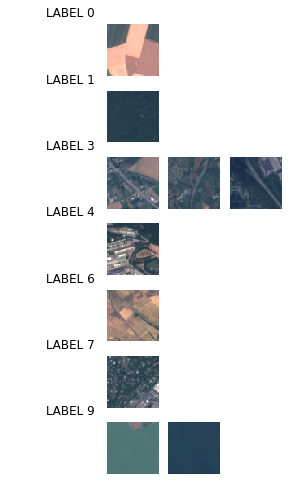

In [8]:
for imgs,labels in train_generator_fn():
    if np.random.random()>.1:
        break
reload(mlutils)        
mlutils.show_labeled_image_mosaic(imgs, labels)

In [9]:
from keras import optimizers
def get_conv_model_A(num_classes, img_size=64, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"  
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(2,2), activation="relu", padding="SAME")(inputs) #, padding="SAME"se debería usar padding por
    #el tamaño pequeño de las imágenes
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu")(layers)
    #layers = tf.keras.layers.Conv2D(60,(11,11), activation="relu")(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    #layers = tf.keras.layers.Conv2D(128,(22,22), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(128, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dense(128, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        #sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        #Optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.3, decay=0, nesterov=False)
        model.compile(optimizer='sgd',#'adam',#Optimizer,
                      loss='sparse_categorical_crossentropy',#tf.keras.losses.mean_squared_error,
                      metrics=['accuracy'])
    return model

In [ ]:
num_classes = len(sub_dirs)
model = get_conv_model_A(num_classes, img_size=img_size)

model.fit_generator(
        train_generator_fn(),
        steps_per_epoch=1000 // batch_size,
        epochs=2,
        validation_data=test_generator_fn(),
        validation_steps=400 // batch_size)

using 10 classes
Found 18900 images belonging to 10 classes.
Found 8100 images belonging to 10 classes.
Epoch 1/2
100/100 [==============================] - 752s 8s/step - loss: 2.2757 - acc: 0.1210 - val_loss: 2.2353 - val_acc: 0.1050
Epoch 2/2
 19/100 [====>.........................] - ETA: 30:11 - loss: 2.1976 - acc: 0.1579

In [78]:
def show_preds(x, preds):
    for i  in np.random.permutation(range(len(preds)))[:4]:
        plt.figure(figsize=(5,2.5))
        plt.subplot(122)
        plt.imshow(x[i])
        plt.axis("off")
        plt.subplot(121)
        plt.bar(np.arange(2), preds[i], color="blue", alpha=.5, label="prediction")
        plt.bar(np.arange(2), np.eye(2,2)[int(y[i])], color="red", alpha=.5, label="label")
        plt.xticks(range(2), range(2), rotation="vertical");
        plt.xlim(-.5,1.5);
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, +1.35),ncol=5)

Found 8100 images belonging to 10 classes.


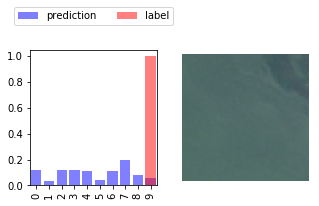

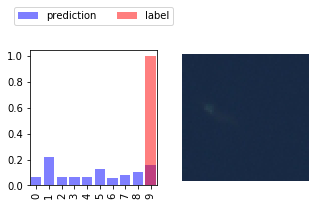

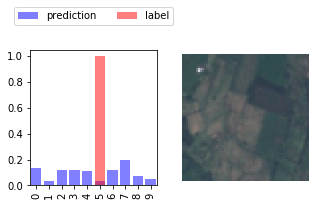

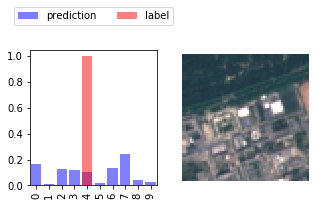

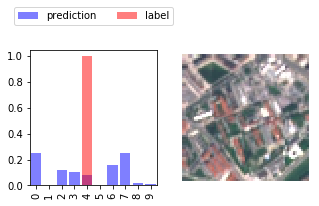

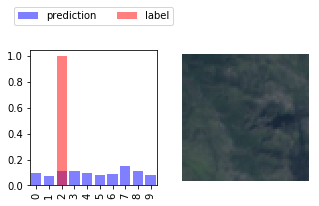

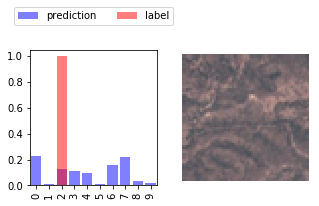

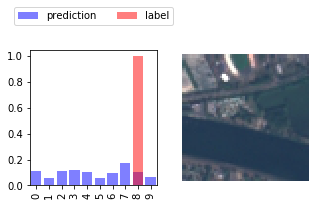

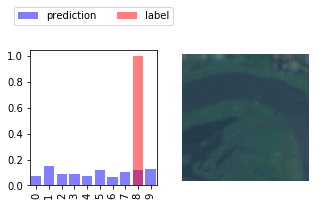

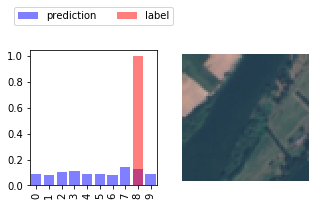

In [79]:
for x,y in test_generator_fn():
    if np.random.random()>.7:
        break
        
#preds = model.predict(x)
preds = model.predict(x)
mlutils.show_preds(x, y, preds)

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 96)        1248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 96)        1115232   
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 96)        0         
_________________________________________________________________
flatten (Flatten)            (None, 46464)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               5947520   
__________

In [81]:
model.history

TypeError: 'History' object is not callable

In [50]:
clases = ['AnnualCrop','Forest','HerbaceousVeg','Highway','Industrial','Pasture', 'PermanentCrop','Residential','River','SeaLake']
clases_dict = dict(enumerate(clases))
clases_dict

{0: 'AnnualCrop',
 1: 'Forest',
 2: 'HerbaceousVeg',
 3: 'Highway',
 4: 'Industrial',
 5: 'Pasture',
 6: 'Residential',
 7: 'River',
 8: 'SeaLake'}

In [63]:
preds[1]

array([0.11945526, 0.06899381, 0.10641597, 0.08759468, 0.13448372,
       0.05254656, 0.12364934, 0.1409161 , 0.08474196, 0.08120257],
      dtype=float32)

In [54]:
mlutils.plot_confusion_matrix(x, preds, classes=clases, normalize=True)


ValueError: Classification metrics can't handle a mix of unknown and continuous-multioutput targets

In [33]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(x, preds)

ValueError: Classification metrics can't handle a mix of unknown and continuous-multioutput targets

In [77]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

modelB = ResNet50(weights='imagenet')

102866944/102853048 [==============================] - 180s 2us/step


In [ ]:
from keras import optimizers
def get_conv_model_A(num_classes, img_size=64, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"  
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(2,2), activation="relu", padding="SAME")(inputs) #, padding="SAME"se debería usar padding por
    #el tamaño pequeño de las imágenes
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu")(layers)
    #layers = tf.keras.layers.Conv2D(60,(11,11), activation="relu")(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    #layers = tf.keras.layers.Conv2D(128,(22,22), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(128, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dense(128, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        #sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        #Optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.3, decay=0, nesterov=False)
        model.compile(optimizer='sgd',#'adam',#Optimizer,
                      loss='sparse_categorical_crossentropy',#tf.keras.losses.mean_squared_error,
                      metrics=['accuracy'])
    return model

In [22]:
!ls -lash data/alexnet_conv1_conv2.pklz

ls: cannot access 'data/alexnet_conv1_conv2.pklz': No such file or directory


In [ ]:
test_preds = model.predict(x).argmax(axis=1)
mlutils.plot_confusion_matrix(y, preds,classes=np.r_[0,1,2,3,4,5,6,7,8,9], normalize=True)

In [ ]:
orig=train(model, batch_size=16, epochs=15, model_name="LandCoverModel")